In [1]:
%env CUDA_VISIBLE_DEVICES=3
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchio

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=3


In [45]:
def t2i(x):
    x = x - x.min()
    x = x / x.max()
    x = x * 255.
    return x

def _pt_ssim(pred, gt):
    from pytorch_msssim import ssim
    return ssim(t2i(pred), t2i(gt), win_size=11)

def pt_ssim(pred, gt):
    from pytorch_msssim import ssim
    return ssim(t2i(pred)[None], t2i(gt)[None], win_size=11)

def ssim_score(pred, gt):
    from k_space_reconstruction.utils.metrics import ssim
    return ssim(pred.cpu().numpy(), gt.cpu().numpy())

def pt_msssim(pred, gt):
    from pytorch_msssim import ms_ssim
    return ms_ssim(t2i(pred)[None], t2i(gt)[None])

def pt_nmse(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    return torch.norm(gt - pred, p=2) ** 2 / torch.norm(gt, p=2) ** 2

def pt_psnr(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    maxval = gt.max()
    mse = torch.mean((pred - gt) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [3]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(2 * nc, 4), dpi=100, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))

def train_sampling_pattern(train_generator, model, n=16, verbose=True, loss_fn=F.l1_loss):
    w = torch.zeros(4,240).cuda().float()
    w[:,120] = 1
    w_list = []
    bbatch_size = 110
    for count in range(int(n * 110 / len(train_generator) + 1)):
        w = torch.autograd.Variable(w, requires_grad=True)
        pbar = tqdm(enumerate(train_generator), total=len(train_generator), leave=False, disable=not verbose)
        for I, (img, ks) in pbar:
            img = img.cuda(); ks = ks.cuda()
            _img = IFt(ks * w.unsqueeze(0).unsqueeze(3)).abs()
            loss = loss_fn(model(_img), img)
            if torch.isnan(loss):
                print('warn')
                continue
            loss.backward()
            if (I != 0) and (I % 110 == 0):
                w_grad = w.grad.cpu().detach()
                w = w.detach()
                for j in range(4):
                    for i in torch.topk(w_grad[j,:], 240, largest=False).indices:
                        if w[j,i] == 0: 
                            w[j,i] = 1.
                            pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                            break
                w_list.append(w.clone())
                w = torch.autograd.Variable(w, requires_grad=True)
                if len(w_list) > n: break
    return w_list


def test_3d_sampling_pattern(sampling, model, val_3d_dataset, metric_fn=pt_ssim):
    displ = 50
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            img, ks = val_3d_dataset[i]
            img = img.cuda(); ks = ks.cuda()
            _img = IFt(ks * sampling).abs()
            dice_scores += [
                metric_fn(model(_img[0][:, displ:-displ,displ:-displ]), img[0][:, displ:-displ,displ:-displ]),
                metric_fn(model(_img[1][:, displ:-displ,displ:-displ]), img[1][:, displ:-displ,displ:-displ]),
                metric_fn(model(_img[2][:, displ:-displ,displ:-displ]), img[2][:, displ:-displ,displ:-displ]),
                metric_fn(model(_img[3][:, displ:-displ,displ:-displ]), img[3][:, displ:-displ,displ:-displ]),
            ]
    return dice_scores


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        if indexes is not None:
            self.indexes = [str(i) for i in indexes]
        else:
            self.indexes = [k for k in self.hf.keys()]

    def __len__(self) -> int:
        return len(self.indexes)
    
    def __getitem__(self, item: int):
        key = self.indexes[item]
        img = self.hf[key][:-1,:,:,:]
        mask = self.hf[key][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        img = img.movedim(3,1)
        ks = Ft(img)
        return img, ks


class BraTS2dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug1=None, aug2=None, slices=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug1 = aug1
        self.aug2 = aug2
        if slices:
            self.slices = slices
        else:
            self.slices = []
            for k in tqdm(self.hf.keys()):
                for j in range(self.hf[k].shape[-1]):
                    if self.hf[k][:,:,:,j].max() != 0.:
                        self.slices.append((k, j))
        if indexes is not None:
            self.slices = [s for s in self.slices if int(s[0]) in indexes]

    def __len__(self) -> int:
        return len(self.slices)
    
    def __getitem__(self, item: int):
        key, idx = self.slices[item]
        img = self.hf[key][:-1,:,:,idx]
        mask = self.hf[key][-1:,:,:,idx]
        mask[mask==4] = 3
        if self.aug1:
            aug = self.aug1(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        if self.aug2:
            img = self.aug2(img.unsqueeze(0))[0]
        ks = Ft(img)
        return img, ks

In [4]:
np.random.seed(42)
torch.manual_seed(42)

with open('brats_train.cache', 'rb') as f:
    train_slices_cache = pickle.load(f)
with open('brats_val.cache', 'rb') as f:
    val_slices_cache = pickle.load(f)

train_dataset = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache)
val_dataset = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5', slices=val_slices_cache)
train_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=32)

In [5]:
len(train_dataset), len(val_dataset), len(train_3d_dataset), len(val_3d_dataset)

(35508, 15391, 258, 111)

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = torch.nn.Identity()

# 5-fold validation x16

In [11]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    td = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache, indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=32)
    w_list = train_sampling_pattern(tg, model, n=14, verbose=True, loss_fn=F.l1_loss)
    print(w_list[-1].sum() / 4)
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w_list[-1].unsqueeze(2).unsqueeze(1), model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()), 
        center=test_3d_sampling_pattern(zm, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
    )
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('l1_fold_scores.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

0it [00:00, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

tensor(16., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

tensor(16., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

tensor(16., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

tensor(16., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

tensor(16., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [15]:
zm.sum(), w_list[-1].sum() / 4

(tensor(16., device='cuda:0'), tensor(16., device='cuda:0'))

In [16]:
import scipy

with open('l1_fold_scores.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-0.9039255078504566, pvalue=0.4171522163228768)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.583937,0.634925,0.634925
std,0.002552,0.003296,0.003296
min,0.580591,0.630945,0.630945
25%,0.582051,0.631767,0.631767
50%,0.584494,0.636797,0.636797
75%,0.586085,0.637193,0.637193
max,0.586462,0.637923,0.637923


# 5-fold validation x8

In [25]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [8])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(30)//2 : 240//2 + int(30)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    td = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache, indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=32)
    w_list = train_sampling_pattern(tg, model, n=28, verbose=True, loss_fn=F.l1_loss)
    print(w_list[-1].sum() / 4, zm.sum())
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w_list[-1].unsqueeze(2).unsqueeze(1), model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()), 
        center=test_3d_sampling_pattern(zm, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
    )
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('l1_fold_scores_x8.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

0it [00:00, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

tensor(30., device='cuda:0') tensor(30., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

tensor(30., device='cuda:0') tensor(30., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

tensor(30., device='cuda:0') tensor(30., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

tensor(30., device='cuda:0') tensor(30., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

tensor(30., device='cuda:0') tensor(30., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [34]:
import scipy

with open('l1_fold_scores_x8.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-0.8468846251851756, pvalue=0.44475443734281034)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.611479,0.732915,0.732915
std,0.002477,0.004227,0.004227
min,0.608339,0.727788,0.727788
25%,0.609410,0.728849,0.728849
50%,0.612594,0.735457,0.735457
75%,0.612903,0.736042,0.736042
max,0.614149,0.736439,0.736439


In [35]:
240 / 5

48.0

# 5-fold x5

In [36]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [5])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(48)//2 : 240//2 + int(48)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    td = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache, indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=32)
    w_list = train_sampling_pattern(tg, model, n=46, verbose=True, loss_fn=F.l1_loss)
    print(w_list[-1].sum() / 4, zm.sum())
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w_list[-1].unsqueeze(2).unsqueeze(1), model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()), 
        center=test_3d_sampling_pattern(zm, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
    )
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('l1_fold_scores_x5.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

0it [00:00, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

tensor(48., device='cuda:0') tensor(48., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

tensor(48., device='cuda:0') tensor(48., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

tensor(48., device='cuda:0') tensor(48., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

tensor(48., device='cuda:0') tensor(48., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

tensor(48., device='cuda:0') tensor(48., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [37]:
import scipy

with open('l1_fold_scores_x5.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=1.1334035323365597, pvalue=0.3203710602094749)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.625428,0.818304,0.818304
std,0.002109,0.003346,0.003346
min,0.622595,0.814498,0.814498
25%,0.623998,0.814798,0.814798
50%,0.625846,0.820382,0.820382
75%,0.627065,0.820917,0.820917
max,0.627634,0.820925,0.820925


# 5-fold x2

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [2])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(120)//2 : 240//2 + int(120)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    td = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache, indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=32)
    w_list = train_sampling_pattern(tg, model, n=118, verbose=True, loss_fn=F.l1_loss)
    print(w_list[-1].sum() / 4, zm.sum())
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w_list[-1].unsqueeze(2).unsqueeze(1), model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()), 
        center=test_3d_sampling_pattern(zm, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
    )
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('l1_fold_scores_x2.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

0it [00:00, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

tensor(120., device='cuda:0') tensor(120., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

tensor(120., device='cuda:0') tensor(120., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

tensor(120., device='cuda:0') tensor(120., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

In [72]:
import scipy

with open('l1_fold_scores_x2.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-39.12552697022311, pvalue=2.549303024735548e-06)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.776778,0.947571,0.948073
std,0.002563,0.002394,0.002402
min,0.774697,0.944345,0.944831
25%,0.774810,0.946116,0.946592
50%,0.775271,0.947884,0.948427
75%,0.779116,0.949142,0.949661
max,0.779995,0.950371,0.950852


In [77]:
img, ks = vd[0]
# _img = IFt(ks * w_list[-1].unsqueeze(2).unsqueeze(1).cpu()).abs()
# _img = IFt(ks * zm.cpu()).abs()

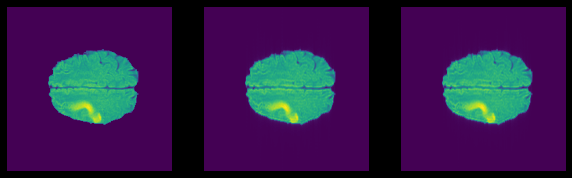

In [85]:
C = 3
N = 110
displ = 50
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(img[C,N][displ:-displ,displ:-displ])
plt.axis('off')
_img1 = IFt(ks * zm.cpu()).abs()
plt.subplot(132)
plt.imshow(_img1[C,N][displ:-displ,displ:-displ])
plt.axis('off')
_img2 = IFt(ks * w_list[-1].unsqueeze(2).unsqueeze(1).cpu()).abs()
plt.subplot(133)
plt.imshow(_img2[C,N][displ:-displ,displ:-displ])
plt.axis('off')
plt.show()

In [86]:
img[C,N][displ:-displ,displ:-displ].shape

torch.Size([140, 140])

In [98]:
240 / 4

60.0

In [99]:
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(60)//2 : 240//2 + int(60)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)

In [103]:
zm.sum(), w_list[-61].sum() / 4

(tensor(60., device='cuda:0'), tensor(60., device='cuda:0'))

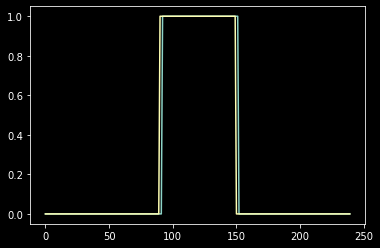

In [107]:
plt.plot(w_list[-61][3].cpu())
plt.plot(zm[0,0,:,0].cpu())

# 5-fold, -ssim loss, x16

In [7]:
240 / 15

16.0

In [8]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    td = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache, indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=32)
    w_list = train_sampling_pattern(tg, model, n=14, verbose=True, loss_fn=lambda x,y : -_pt_ssim(x, y))
    print(w_list[-1].sum() / 4, zm.sum())
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w_list[-1].unsqueeze(2).unsqueeze(1), model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()), 
        center=test_3d_sampling_pattern(zm, model, vd, metric_fn=lambda x,y: pt_ssim(x,y).item()),
    )
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('ssim_fold_scores_x16.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

0it [00:00, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

tensor(16., device='cuda:0') tensor(16., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

tensor(16., device='cuda:0') tensor(16., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

tensor(16., device='cuda:0') tensor(16., device='cuda:0')


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

tensor(16., device='cuda:0') tensor(16., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

tensor(16., device='cuda:0') tensor(16., device='cuda:0')


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [9]:
import scipy

with open('ssim_fold_scores_x16.pkl', 'rb') as f: fold_scores = pickle.load(f)

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-5.382906061709375, pvalue=0.005757451381734916)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.589159,0.634925,0.681211
std,0.002513,0.003296,0.020132
min,0.586017,0.630945,0.655104
25%,0.587018,0.631767,0.673344
50%,0.589985,0.636797,0.674454
75%,0.591074,0.637193,0.700421
max,0.591699,0.637923,0.702731


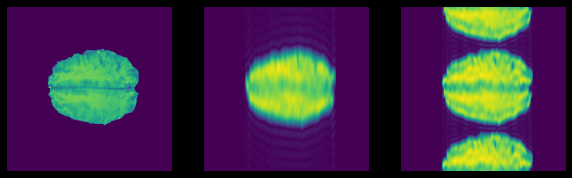

In [14]:
C = 0
N = 110
displ = 1

img, ks = vd[0]

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(img[C,N][displ:-displ,displ:-displ])
plt.axis('off')
_img1 = IFt(ks * zm.cpu()).abs()
plt.subplot(132)
plt.imshow(_img1[C,N][displ:-displ,displ:-displ])
plt.axis('off')
_img2 = IFt(ks * w_list[-1].unsqueeze(2).unsqueeze(1).cpu()).abs()
plt.subplot(133)
plt.imshow(_img2[C,N][displ:-displ,displ:-displ])
plt.axis('off')
plt.show()

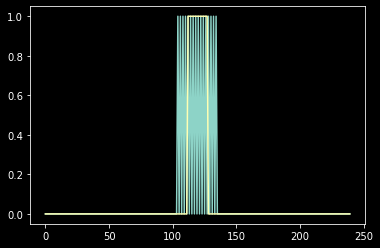

In [19]:
plt.plot(w_list[-1][2].cpu())
plt.plot(zm[0,0,:,0].cpu())

# Train of full train

In [23]:
tg = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
w = train_sampling_pattern(tg, model, n=14, loss_fn=lambda x,y : -_pt_ssim(x, y))[-1]
torch.save(w, 'sampling_igs.pt')

  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/1110 [00:00<?, ?it/s]

In [46]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()
w = torch.load('sampling_igs.pt')

ssim_scores = dict(
    ours=test_3d_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model, val_3d_dataset, metric_fn=lambda x,y: pt_ssim(x,y).item()),
    fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, val_3d_dataset, metric_fn=lambda x,y: pt_ssim(x,y).item()), 
    center=test_3d_sampling_pattern(zm, model, val_3d_dataset, metric_fn=lambda x,y: pt_ssim(x,y).item()),
)

psnr_scores = dict(
    ours=test_3d_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model, val_3d_dataset, metric_fn=lambda x,y: pt_psnr(x,y).item()),
    fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, val_3d_dataset, metric_fn=lambda x,y: pt_psnr(x,y).item()), 
    center=test_3d_sampling_pattern(zm, model, val_3d_dataset, metric_fn=lambda x,y: pt_psnr(x,y).item()),
)

nmse_scores = dict(
    ours=test_3d_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model, val_3d_dataset, metric_fn=lambda x,y: pt_nmse(x,y).item()),
    fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, val_3d_dataset, metric_fn=lambda x,y: pt_nmse(x,y).item()), 
    center=test_3d_sampling_pattern(zm, model, val_3d_dataset, metric_fn=lambda x,y: pt_nmse(x,y).item()),
)

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

In [47]:
print('SSIM')
print(pd.DataFrame.from_dict(ssim_scores).describe())
print('PSNR')
print(pd.DataFrame.from_dict(psnr_scores).describe())
print('NMSE')
print(pd.DataFrame.from_dict(nmse_scores).describe())

SSIM
             ours     fastmri      center
count  444.000000  444.000000  444.000000
mean     0.678320    0.588244    0.634622
std      0.058814    0.042497    0.045740
min      0.508130    0.474985    0.499851
25%      0.632292    0.556832    0.600713
50%      0.681242    0.585753    0.630925
75%      0.724113    0.615786    0.665360
max      0.811766    0.773260    0.801759
PSNR
             ours     fastmri      center
count  444.000000  444.000000  444.000000
mean    20.353934   18.753297   20.969170
std      3.092664    2.914098    3.144495
min     11.300863   11.215660   11.811323
25%     18.584855   16.678213   19.113338
50%     20.808184   19.240567   21.503724
75%     22.628105   20.902795   23.123955
max     29.269440   26.162340   30.286779
NMSE
             ours     fastmri      center
count  444.000000  444.000000  444.000000
mean     0.268625    0.434309    0.263093
std      0.271856    0.451820    0.289546
min      0.033384    0.047050    0.028401
25%      0.113537  

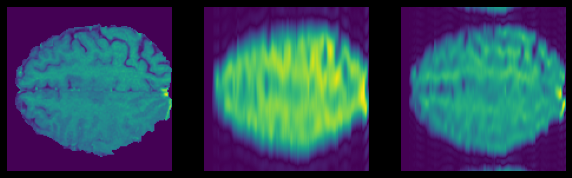

13.09309196472168
19.601226806640625


In [48]:
C = 2
N = 110
displ = 50

img, ks = val_3d_dataset[0]

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(img[C,N][displ:-displ,displ:-displ])
plt.axis('off')
_img1 = IFt(ks * zm.cpu()).abs()
plt.subplot(132)
plt.imshow(_img1[C,N][displ:-displ,displ:-displ])
plt.axis('off')
_img2 = IFt(ks * w.unsqueeze(2).unsqueeze(1).cpu()).abs()
plt.subplot(133)
plt.imshow(_img2[C,N][displ:-displ,displ:-displ])
plt.axis('off')
plt.show()

print(pt_psnr(_img1[C,N][displ:-displ,displ:-displ][None], img[C,N][displ:-displ,displ:-displ][None]).item())
print(pt_psnr(_img2[C,N][displ:-displ,displ:-displ][None], img[C,N][displ:-displ,displ:-displ][None]).item())